In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

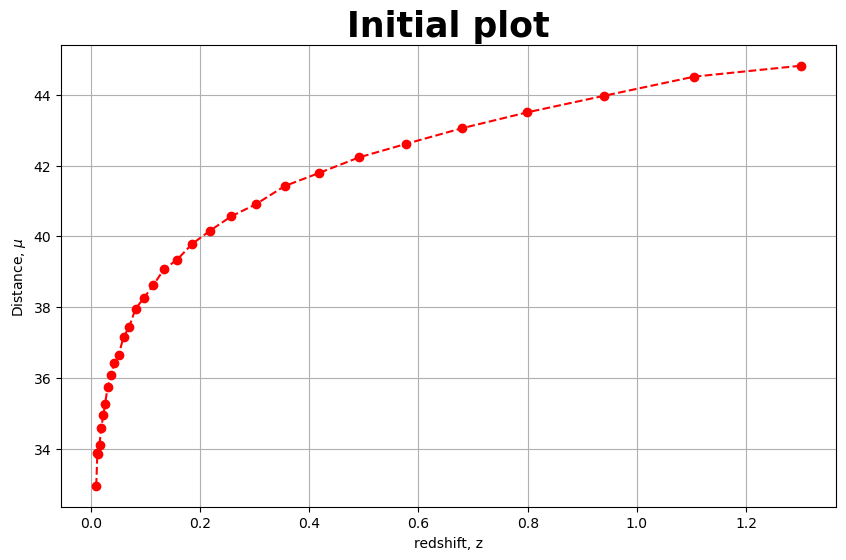

In [ ]:
# Extracting data from Text file
Data_z_and_u = np.genfromtxt('/home/parth-kothari/Metropolis-Hastings-Monte-Carlo-Markov-Chain/Data/jla_mub_0.txt')
Covariance = np.genfromtxt('/home/parth-kothari/Metropolis-Hastings-Monte-Carlo-Markov-Chain/Data/jla_mub_covmatrix.txt')

redshift = Data_z_and_u[:,0]
Distance = Data_z_and_u[:,1]

plt.rcParams["figure.figsize"] = (10, 6) #global size

# Initial plot to visualize the data
plt.plot(redshift,Distance,'--o',color= 'red')
plt.xlabel('redshift, z')
plt.ylabel('Distance, $ \mu $ ')
plt.title('Initial plot', fontweight= 'bold' ,fontsize = 25)
plt.grid()
# plt.savefig('Initial plot')
plt.show()

# Functions defined for the different cosmological equations

In [4]:
# Defining  Functions


# Eta function that will go into Luminosity Function
def eta(a,omega_m):
    s = np.cbrt((1 - omega_m)/omega_m)
    eta_calculated_fit = 2 *(np.sqrt(s**3 + 1) ) * ( (1/a**4) - ( (0.1540*s)/a**3) + ((0.4304*s**2)/a**2) + ((0.19097*s**3)/a) + (0.066941*s**4)  )**(-1/8)
    return eta_calculated_fit

#Luminosity Distance calculated from the fit formula using Eta
def Luminosity_distance(z,omega_m_lum):   #h = 1
    D_L = 3000 * (1 + z) * (eta(1,omega_m_lum) - eta(1 / (1 + z),omega_m_lum) )
    return D_L 

# Distance Modulus Calculation using Distance Luminosity D_L already IN MPC
def mu(z,omega_m_mu,h):
    D = Luminosity_distance(z,omega_m_mu)
    Distance_modulus = 25 - (5 * np.log10(h)) + (5 * np.log10(D))
    return Distance_modulus

# MH-MCMC Function: Likelihood and MH algorithm

In [5]:
# Reshaped the Covariance Matrix and took inverse of it as it is needed in Likelihood
Reshaped_covariance_matrix = np.reshape(Covariance,(31,31))
Inverse_Covariance_matrix = np.linalg.inv(Reshaped_covariance_matrix)

# MCMC Algorithm

# Defining Likelihood. MHMC uses Log as likelihood Therefore Taking Natural Log of Ln to get new liklehood.
def likelihood(Omga, h, redshift,Distance):
    C = np.zeros(31)   #Array to store the difference values betwwen Theoretical mu(Omega and h will be supplied by the random sampling) and Data mu.
    if Omga <= 0.0 or h <= 0.0: # Restricting the values to remain between 0 and 1. Its negative as we have taken log, The negative sign in will be positive.
        likely = -1.e100
    elif Omga>1 or h > 1:
        likely = -1.e100
    else:
        C[:] = Distance - mu(redshift,Omga,h)  # The likely hood function here
        V = np.dot(Inverse_Covariance_matrix,C)
        likely =  -0.5 * np.dot(C,V) 
    
    return likely
# likelihood(0.3,0.7,redshift,Distance)     Its negative because we have taken log

# The main function of metropolis Hastings algorithm

def Metro_Monte(Omega_MC_previous,h_MC_previous,Var_Om_proposal,Var_h_proposal): 
    Omega_next = np.abs(Omega_MC_previous + Var_Om_proposal * np.random.randn() ) #Curren value of Omega + variance (step) of proposed gaussian distribution
    h_next = np.abs( h_MC_previous + Var_h_proposal * np.random.randn() )

    log_posterior_old = likelihood(Omega_MC_previous,h_MC_previous,redshift,Distance) # Calculating likelihood of the point.
    log_posterior_new = likelihood(Omega_next,h_next,redshift,Distance)

    #Taking Ratio to get The alpha ratio.
    Acceptance_ratio = log_posterior_new - log_posterior_old
    if np.log(np.random.normal(0,1)) < Acceptance_ratio: # accepting values even if it's below 1.
        return Omega_next,h_next,'Yes'
    else:
        return Omega_MC_previous,h_MC_previous,'No'



# Initial plotting to see which values of h and $\Omega_{m}$ best fits the data

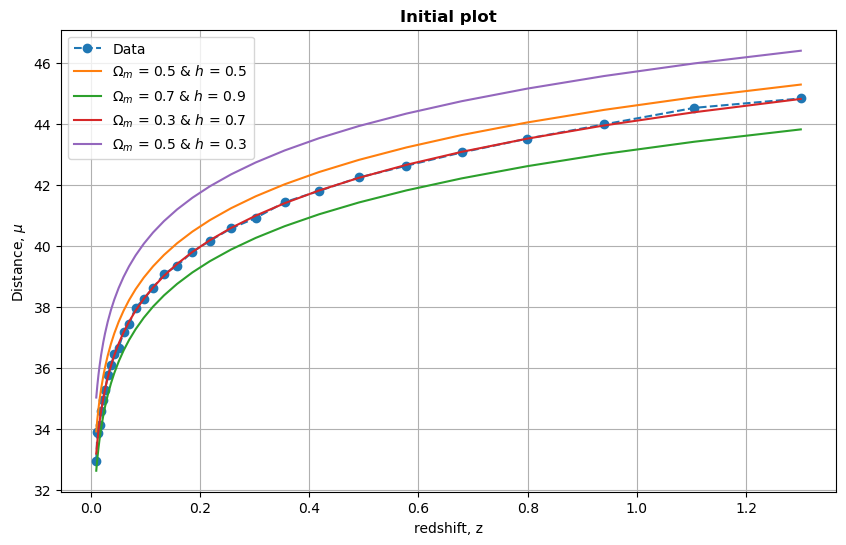

In [ ]:
# Random Plotting to see what Values of h and Omega are best fit for the data

plt.plot(redshift,Distance,'--o',label='Data')
plt.plot(redshift,mu(redshift,0.5,0.5),label = '$\Omega_{m} $ = 0.5 & $h$ = 0.5')
plt.plot(redshift,mu(redshift,0.7,0.9),label = '$\Omega_{m} $ = 0.7 & $h$ = 0.9 ')
plt.plot(redshift,mu(redshift,0.3,0.7),label = '$\Omega_{m} $ = 0.3 & $h$ = 0.7 ')
plt.plot(redshift,mu(redshift,0.5,0.3),label = '$\Omega_{m} $ = 0.5 & $h$ = 0.3 ')

# 0.3 and 0.7 are the most likely values for the Given Data
plt.xlabel('redshift, z')
plt.ylabel('Distance, $ \mu $ ')
plt.title('Initial plot',fontweight= 'bold')
plt.legend()
plt.grid()
# plt.savefig('Various tries for h and omega')
plt.show()

# Random Walk: Function takes value of width of proposal, Initial guess and Number of iterations

In [7]:
def MHMC_plot(Variance_Om, Variance_h, Guess_Om, Guess_h, Iteration):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 subplot grid
    
    Initial_Omega_guess = [Guess_Om]
    Initial_h_guess = [Guess_h]
    likelihood_values = []
    N = Iteration   # Number of iterations
    
    for i in range(1, N):                       # Iterations begin here
        omega_p = Initial_Omega_guess[-1]
        h_p = Initial_h_guess[-1]

        omega_next, h_next, condition = Metro_Monte(omega_p, h_p, Variance_Om, Variance_h)
        if condition == 'Yes':
            Initial_Omega_guess.append(omega_next)  # Appending values that are accepted along with it's likelihood
            Initial_h_guess.append(h_next)
            likelihood_values.append(likelihood(omega_next, h_next, redshift, Distance))
        else:
            continue 
        
    acceptance_percent = (len(likelihood_values) / N) * 100   # Acceptance percentage
    burn_in_points = round(5 * (acceptance_percent))    #Burn in Only for specific distribution

    Afterburn_h = Initial_h_guess[burn_in_points:]
    Afterburn_Omega = Initial_Omega_guess[burn_in_points:]
    Mean_omega = np.mean(Afterburn_Omega)
    Mean_h = np.mean(Afterburn_h)
    Var_omega = np.var(Afterburn_Omega)
    Var_h = np.var(Afterburn_h)
    Covariance_h_and_omega = np.cov(Afterburn_Omega, Afterburn_h)[0, 1]

    print(f'Acceptance percentage: {acceptance_percent}%')
    print("Burned Points:", burn_in_points)
    print(f'Average value of $\Omega_m$: {Mean_omega} ; Average value of h: {Mean_h}')
    print(f'Variance in $\Omega_m$:{Var_omega} ; Variance in h:{Var_h} ')
    print(f'Covariance between Omega_matter and h = {Covariance_h_and_omega} ')
    
    # Plot the scatter plot on the first subplot
    scatter = axs[0, 0].scatter(Initial_Omega_guess[1:], Initial_h_guess[1:], c=likelihood_values, cmap='bwr')
    cbar = plt.colorbar(scatter, ax=axs[0, 0], location='left')
    cbar.set_label('Likelihood, $L$ in log scale')
    axs[0, 0].set_title(f"MH-MCMC, For Proposal width $\Omega_m$={Variance_Om} and h = {Variance_h}",fontweight= 'bold' )
    axs[0, 0].set_xlabel("$\Omega_{m} $")
    axs[0, 0].set_ylabel("$h$")
    
    # Plot the data and the theoretical curve on the second subplot
    axs[0, 1].plot(redshift, Distance, '--o', color='Magenta', label='Data')
    axs[0, 1].plot(redshift, mu(redshift, Mean_omega, Mean_h),color = 'Blue' ,label=f'$\Omega_m$ = {Mean_omega:.2f} & $h$ = {Mean_h:.2f}')
    axs[0, 1].legend()
    axs[0, 1].set_title('Data VS Theory Fit',fontweight = 'bold')
    axs[0, 1].set_xlabel("Redshift, $z$")
    axs[0, 1].set_ylabel("Distance Modulus")
    axs[0, 1].grid()
    
    # Plot histograms for Omega_m and h on the third and fourth subplots
    axs[1, 0].hist(Afterburn_Omega, bins=20, color='green', alpha=0.7,edgecolor = 'black')
    axs[1, 0].set_title('Histogram of Afterburn $\Omega_m$', fontweight='bold')
    axs[1, 0].set_xlabel("$\Omega_m$")
    axs[1, 0].set_ylabel("Frequency")
    
    axs[1, 1].hist(Afterburn_h, bins=20, color='orange', alpha=0.7,edgecolor = 'black')
    axs[1, 1].set_title('Histogram of Afterburn $h$', fontweight='bold')
    axs[1, 1].set_xlabel("$h$")
    axs[1, 1].set_ylabel("Frequency")
    
    plt.tight_layout()  
    return Initial_Omega_guess, Initial_h_guess



# Plots

## Widths for proposal:
### $  \sigma(\Omega_{m})$ = 0.01 ; $ \sigma(h)$ = 0.01 

Acceptance percentage: 23.7%
Burned Points: 118
Average value of $\Omega_m$: 0.2929264774496222 ; Average value of h: 0.7040581291804541
Variance in $\Omega_m$:0.0003010729928655023 ; Variance in h:4.90186843640426e-05 
Covariance between Omega_matter and h = -5.1591900248792126e-05 


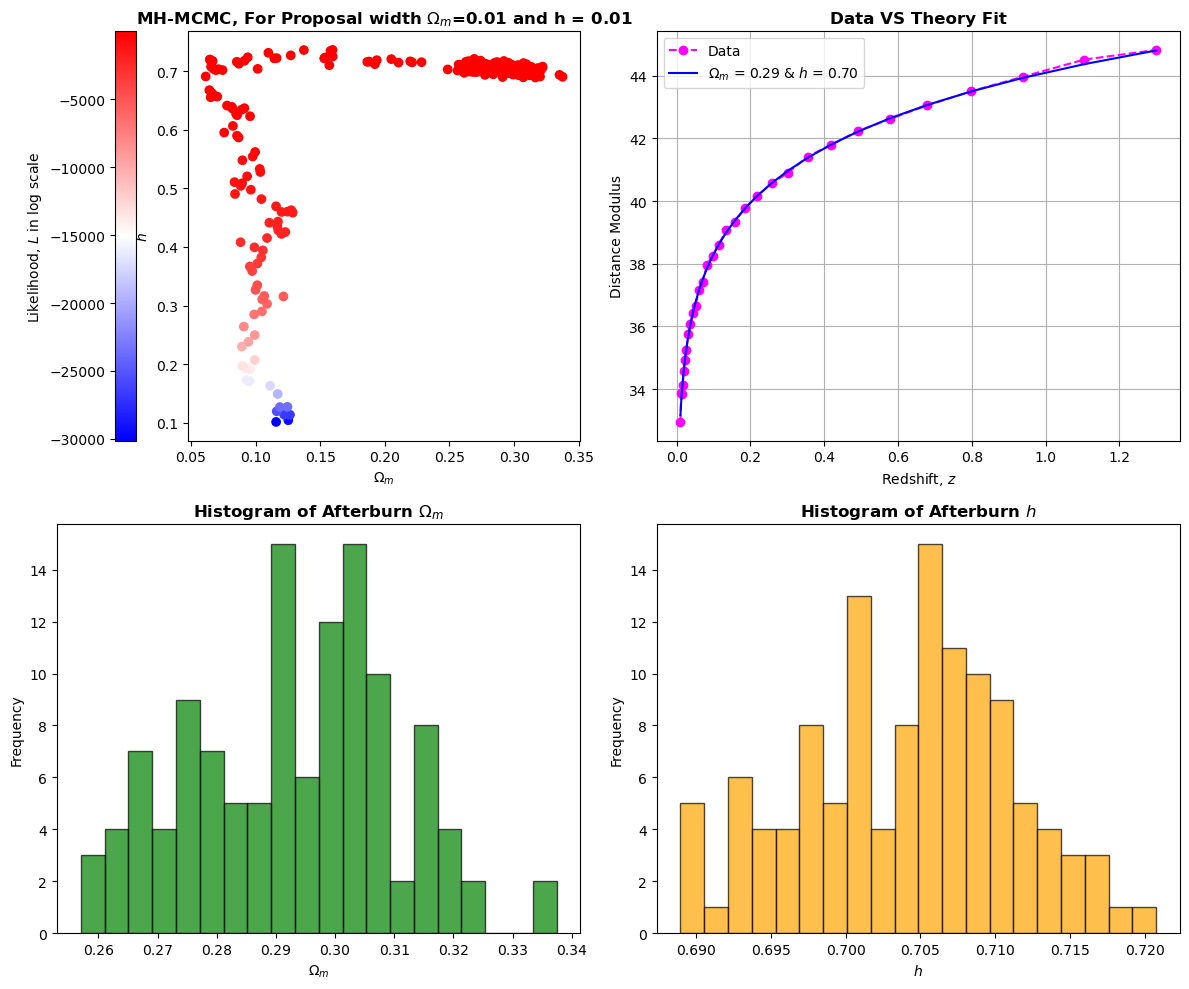

In [8]:
A,B = MHMC_plot(0.01,0.01,0.1,0.1,1000)  
# plt.savefig('Random walk')


### $\Omega_{m}$ = 0.001 ; $ h$ = 0.001 

Acceptance percentage: 24.9%
Burned Points: 124
Average value of $\Omega_m$: 0.11190475775033096 ; Average value of h: 0.2526660011124428
Variance in $\Omega_m$:1.3857809047842873e-05 ; Variance in h:0.0006445734149310639 
Covariance between Omega_matter and h = 7.714282090222342e-05 


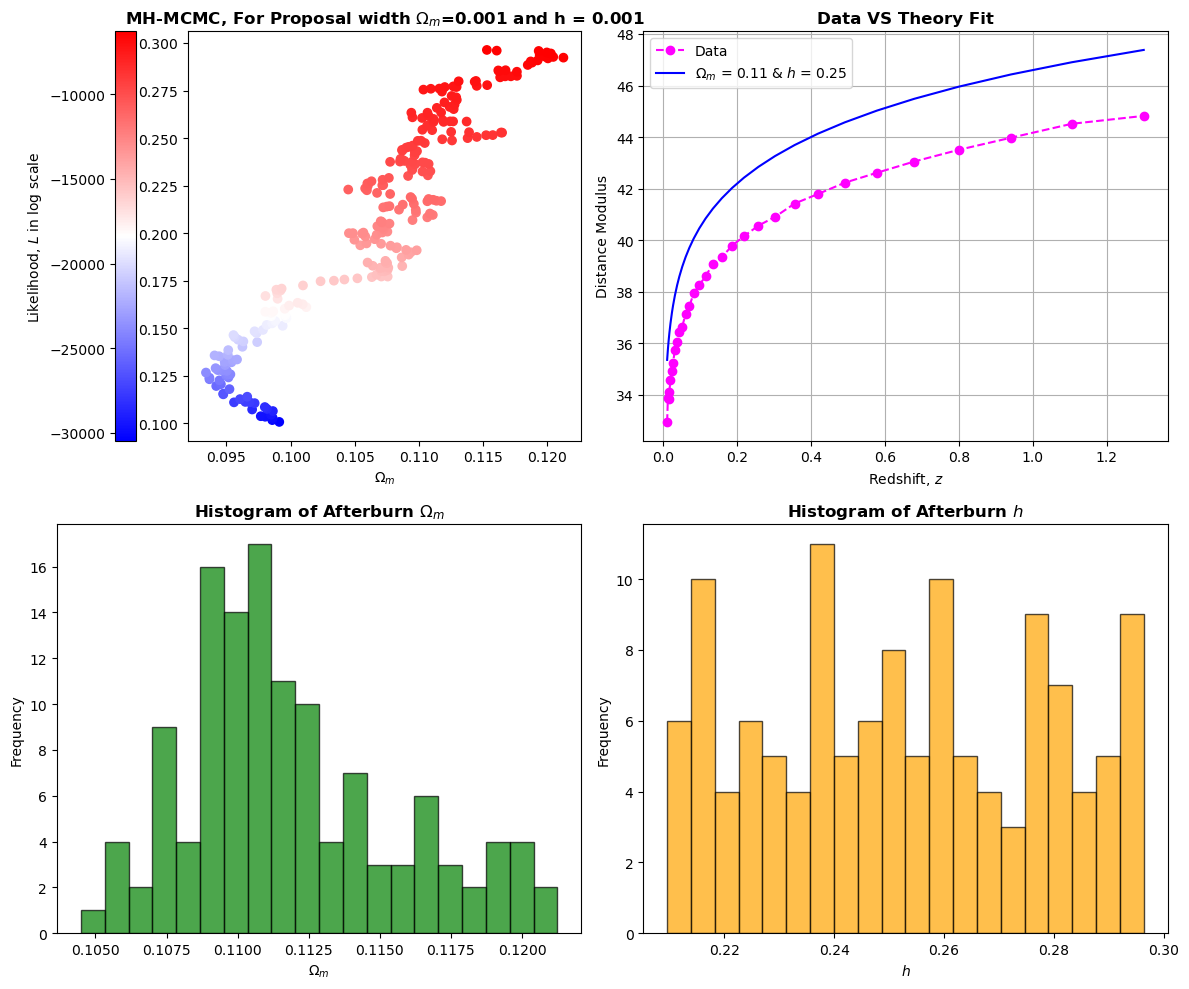

In [9]:
C,D = MHMC_plot(0.001,0.001,0.1,0.1,1000)

### $\Omega_{m}$ = 100 ; $ h$ = 100

Acceptance percentage: 0.0%
Burned Points: 0
Average value of $\Omega_m$: 0.1 ; Average value of h: 0.1
Variance in $\Omega_m$:0.0 ; Variance in h:0.0 
Covariance between Omega_matter and h = nan 


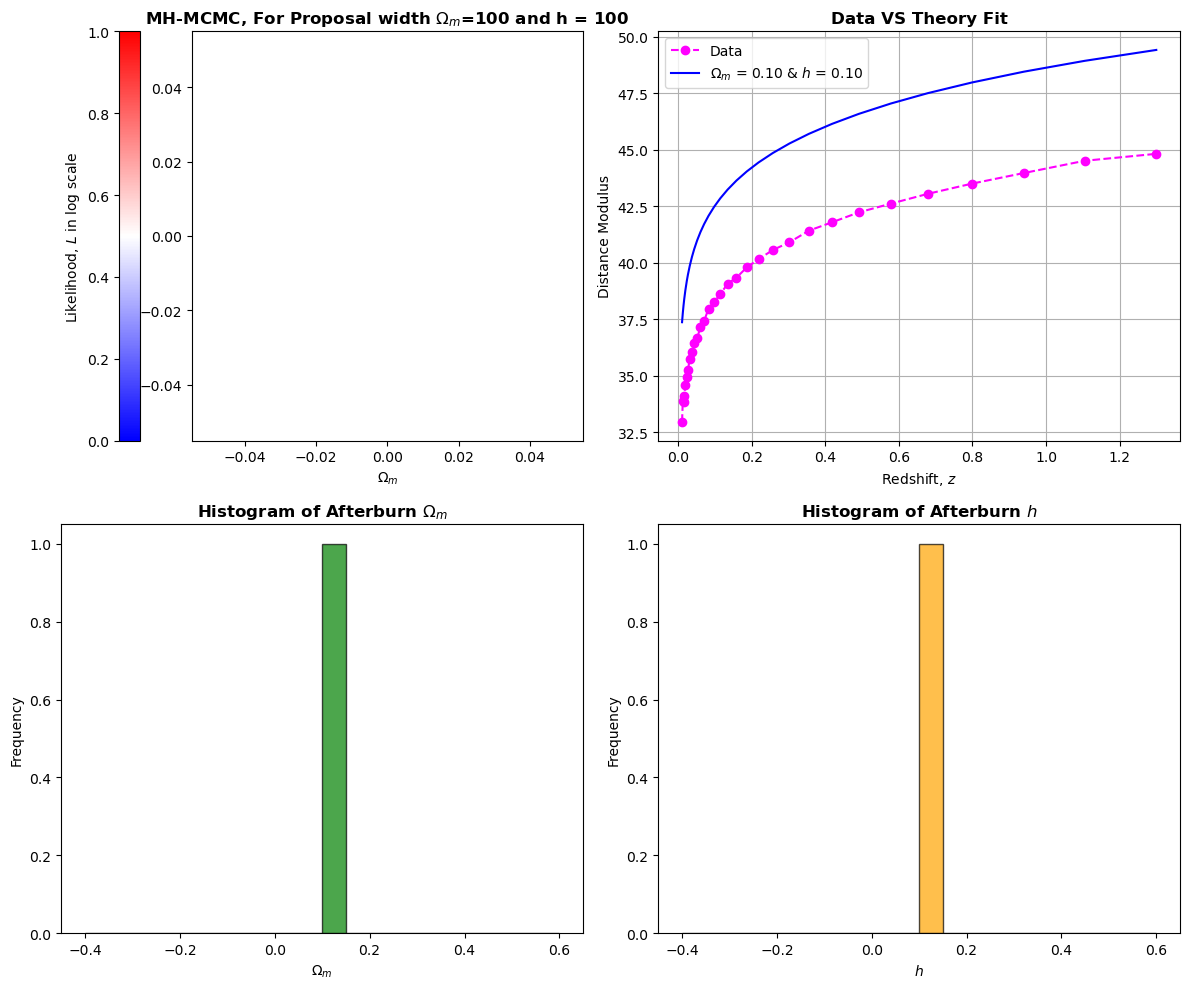

In [10]:
E,F = MHMC_plot(100,100,0.1,0.1,1000)

### $\Omega_{m}$ = 1.0 ; $ h$ = 1.0 

Acceptance percentage: 0.6%
Burned Points: 3
Average value of $\Omega_m$: 0.44386336020271766 ; Average value of h: 0.6917952109322582
Variance in $\Omega_m$:0.04663976913179055 ; Variance in h:0.0035049334327025695 
Covariance between Omega_matter and h = -0.013951463313021918 


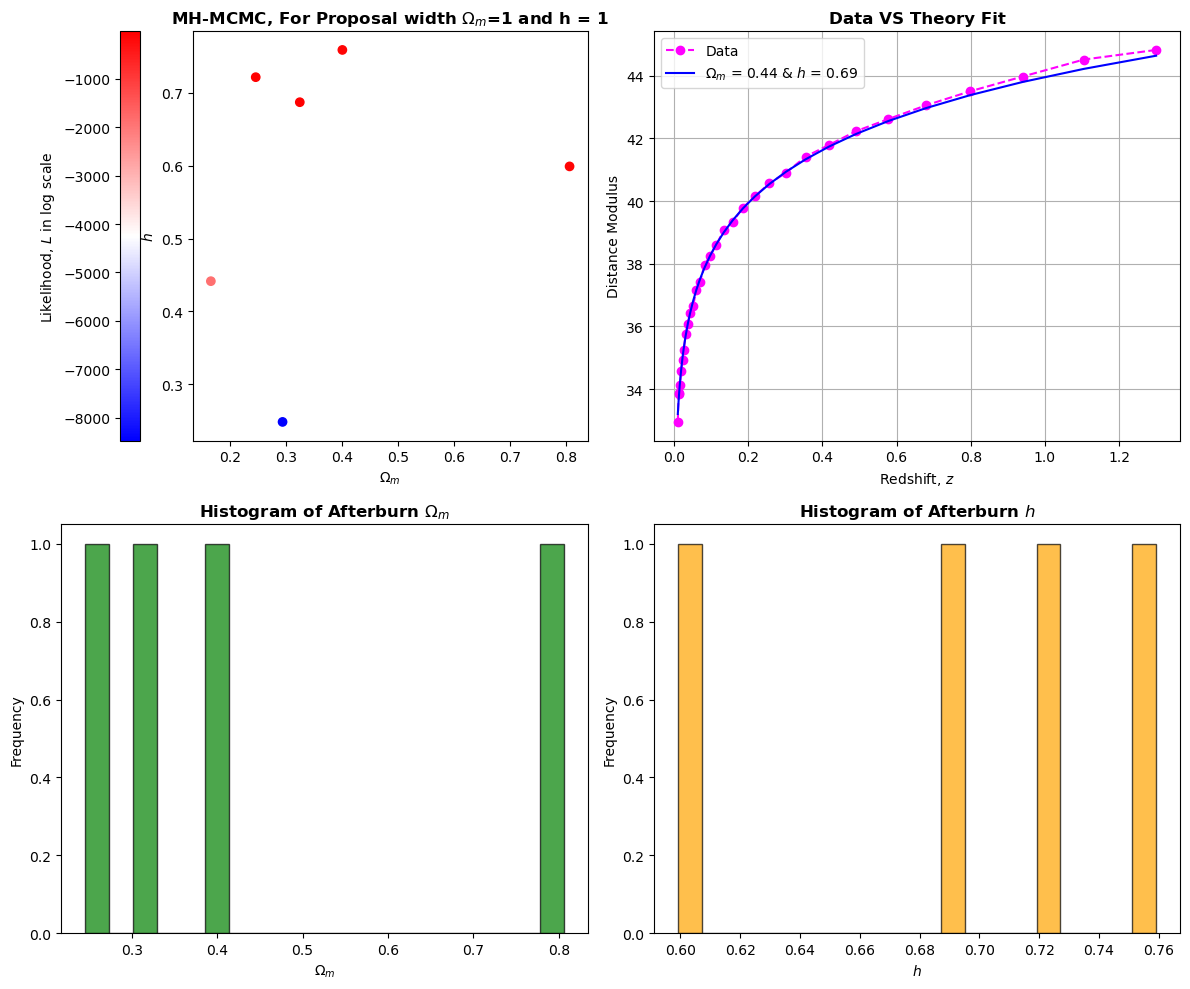

In [11]:
G,H = MHMC_plot(1,1,0.1,0.1,1000)

## Burn - In refrence to calculate number of burned points
### $\Omega_{m}$ = 0.01 ; $ h$ = 0.01 

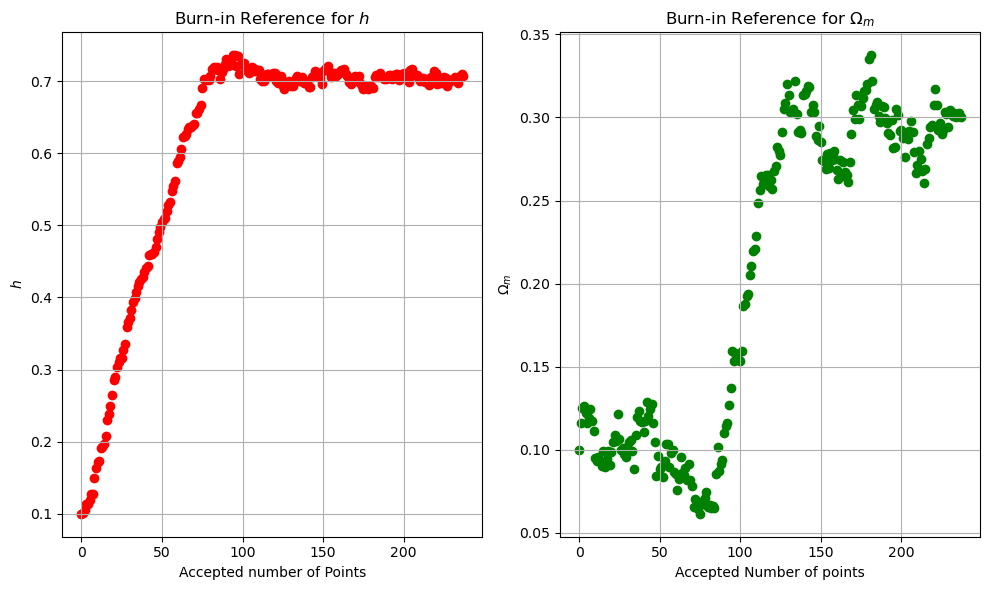

In [12]:
#  Plotting the burn-in reference for h
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.scatter(range(len(B)), B,color = 'Red')
plt.title('Burn-in Reference for $h$')
plt.xlabel('Accepted number of Points')
plt.ylabel('$h$')
plt.grid()

# Plotting the burn-in reference for Omega_m
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.scatter(range(len(A)), A,color = 'Green')
plt.title('Burn-in Reference for $\Omega_m$')
plt.xlabel('Accepted Number of points')
plt.ylabel('$\Omega_m$')

plt.grid()
plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig('Burn in')
plt.show()